In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [33]:
train_df = pd.read_csv("kdd_train.csv")
test_df = pd.read_csv("kdd_test.csv")

In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  int64  
 2   service                      125973 non-null  int64  
 3   flag                         125973 non-null  int64  
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [34]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nFirst 5 rows of training data:")
print(train_df.head())

Train shape: (125973, 42)
Test shape: (22544, 42)

First 5 rows of training data:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.0

In [46]:
train_df['protocol_type'].value_counts()

protocol_type
1    102689
2     14993
0      8291
Name: count, dtype: int64

In [47]:
train_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack_binary'],
      dtype='object')

In [35]:
# Check for Missing Values
print("\nChecking missing values...")
print(train_df.isnull().sum().sum(), "missing values in train data")
print(test_df.isnull().sum().sum(), "missing values in test data")


Checking missing values...
0 missing values in train data
0 missing values in test data


In [36]:
# Remove duplicates (if any)
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

In [37]:
# Identify categorical features
categorical_cols = ['protocol_type', 'service', 'flag']

In [38]:
# Encode them using LabelEncoder (same encoder for train & test)
encoder = LabelEncoder()

In [39]:
for col in categorical_cols:
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0)
    encoder.fit(combined_data)
    train_df[col] = encoder.transform(train_df[col])
    test_df[col] = encoder.transform(test_df[col])

In [40]:
# For binary classification (Normal=0, Attack=1)
train_df['attack_binary'] = train_df['labels'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['attack_binary'] = test_df['labels'].apply(lambda x: 0 if x == 'normal' else 1)

C:\Users\Dev Bhatt\AppData\Local\Temp\ipykernel_22520\1271311785.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='attack_binary', data=train_df, palette='Set1')


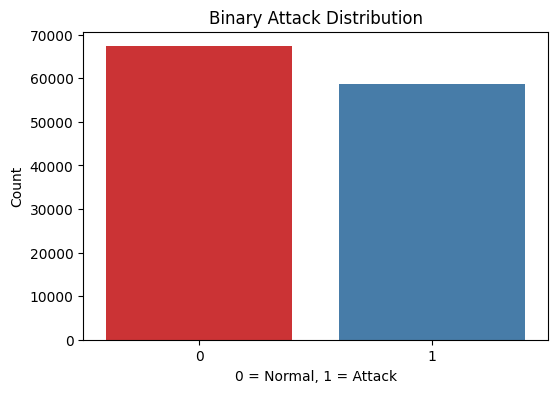

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='attack_binary', data=train_df, palette='Set1')
plt.title('Binary Attack Distribution')
plt.xlabel('0 = Normal, 1 = Attack')
plt.ylabel('Count')
plt.show()

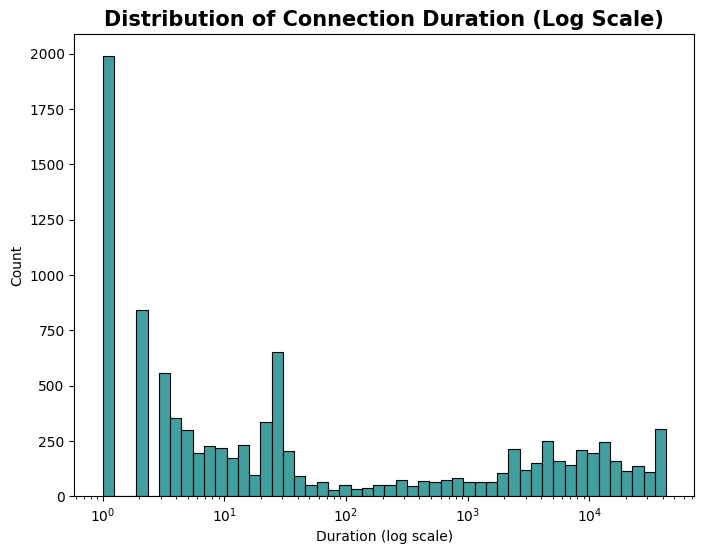

In [53]:
plt.figure(figsize=(8,6))
sns.histplot(train_df['duration'], bins=50, log_scale=True, color='teal')
plt.title('Distribution of Connection Duration (Log Scale)', fontsize=15, fontweight='bold')
plt.xlabel('Duration (log scale)')
plt.show()

In [41]:
train_df.drop(['labels'], axis=1, inplace=True)
test_df.drop(['labels'], axis=1, inplace=True)

In [42]:
#Separate Features and Labels
X_train = train_df.drop(['attack_binary'], axis=1)
y_train = train_df['attack_binary']

X_test = test_df.drop(['attack_binary'], axis=1)
y_test = test_df['attack_binary']

In [43]:
#Standardize Numerical Features
scaler = StandardScaler()

In [44]:
# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data preprocessing completed successfully!")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


✅ Data preprocessing completed successfully!
X_train_scaled shape: (125973, 41)
X_test_scaled shape: (22513, 41)
